# Solving PDEs
This notebook is an introduction on how to use *esys-escript* to solve partial differential equations.  Scripts for *esys-escript* are written in *python*. 
There are many online resources for help with *python*, including [The Python Tutorial](https://docs.python.org/3/tutorial/index.html).  

## Poisson's equation on a unit square  
<figure>
    <center>
    <img src="figures/PoissonDomain2.png", width="400">
    </center>
    <center>
    <caption>The domain $\Omega=[0,1]^2=\{ (x_0;x_1)~|~0\le x_{0} \le 1 \mbox{ and } 0\le x_{1} \le 1 \}$ and boundaries, Dirichlet (red) and Neumann (black).
        </caption></center>
 </figure>


Solve
\begin{equation}
   \frac{\partial^2 u}{\partial x_0^2} 
    + \frac{\partial^2 u}{\partial  x_1^2}=f 
    \tag{1}
\end{equation}
for $u$, where $f$ is the given right hand side with Neumann boundary conditions on the top and left boundaries as marked 
\begin{equation}
  \frac{\partial u}{\partial n} = 0, \mbox { for } x_0=1 \mbox { or } x_1 = 1
\end{equation}
and zero Dirichlet boundary conditions on the bottom and left boundaries
\begin{equation}
   u = 0, \mbox { for } x_0=0 \mbox { or } x_1 = 0.
\end{equation}

This PDE with boundary conditions is a boundary value problem (BVP) for unknown $u$.  In general, BVPs cannot be solved analytically and numerical methods are used to construct an approximation of the solution $u$. *esys-escript* uses the finite element method (FEM).  There are many resources available to give more detail on the FEM including [Zienkiewicz](https://www.sciencedirect.com/book/9781856176330/the-finite-element-method-its-basis-and-fundamentals).  If *esys-escript* is installed on the computer, it can be run interactively in a terminal with the command **run-escript** and the following commands can be copied into the terminal.  It is more efficient to run *esys-escript* as a python script than interactively.

There are 4 steps:
1. Define the domain.
2. Define the PDE and boundary conditions.
3. Solve the PDE.
4. Output the results through visualisation and/or values.

### Step 1. Define the domain.
In the **Domain** class, objects are used to describe the geometry of a domain and information about the discretization and solver methods. The simplest 2D domain can be created using *esys-finley* function Rectangle. For more complicated domains, [gmsh](https://gitlab.onelab.info/gmsh/gmsh) can be used as well as [pygmsh](https://github.com/meshpro/pygmsh), see [simple examples](ADD). 

Functions used by the scripts are imported.  The first line of code below imports Rectangle from *esys-finley*.

Function **Rectangle** assumes that the bottom left corner coordinate is $(0,0)$ and has four inputs: l0, l1, n0, and n1.  The top right corner of the domain is given by (l0, l1) and n0 and n1 are the number of elements in the $x_0$ and $x_1$ directions respectively.  In this example the top right corner is (1,1) and there are 40 elements horizontally and 20 elements vertically.   

In [199]:
from esys.finley import Rectangle
mydomain = Rectangle(l0=1.,l1=1.,n0=40, n1=20)

### Step 2.  Define the PDE and boundary conditions

In *esys-escript*, the easiest way to define this pde is using the **Poisson** class. A more general way to define PDEs is with the [LinearPDE class](http://localhost:8888/lab/tree/eenotes/Notebooks/UserGuide/Chapter4.ipynb).  The **Poisson** class is imported, the pde is defined on the domain, and the right hand side value f is assigned with **setValue()**.

In [200]:
from esys.escript.linearPDEs import Poisson 
mypde = Poisson(mydomain)
mypde.setValue(f=1)

The **Poisson** class implicitly assumes homogeneous Neuman boundary conditions, $\frac{\partial u}{\partial n} = 0$ on all boundaries. With just this boundary condition, there is no unique solution.  If $u$ is a solution, then $u+C$, where $C$ is a constant, is also a solution. The Dirichlet boundary condition needs to be added. Dirichlet boundaries are imposed by defining a function that is positive where the Dirichlet boundary condition is to be imposed and is zero everywhere else.  For this example, we need to define a function that is positive when $x_0=0$ and $x_1=0$.  **Domain** function **getX()** is used to create an object that contains the coordinates of the finite element nodes in the mesh:

In [201]:
x = mydomain.getX()

Object x is a [Data object](ADD_LINK) and has a **Rank** (number of dimensions) and **Shape** (list of dimensions) that can be viewed by calling the methods **getRank()** and **getShape()**:

In [202]:
print("rank ",x.getRank(),"\nshape ",x.getShape())

rank  1 
shape  (2,)


This means that x is a vector with two components.  The **Data** object also maintains type information represented by the [FunctionSpace](http://localhost:8888/lab/tree/eenotes/Notebooks/cookbook/Chapter_2.ipynb) of the object. Values can be stored on the finite element nodes or within the finite elements at numerical integration (quadrature) points or at one point within the elements.  There are also funcpaces for the boundaries of the domain. 

In [203]:
print("function space ",x.getFunctionSpace())

function space  Finley_Nodes [ContinuousFunction(domain)] on FinleyMesh


The coordinates are stored on the nodes of (rather than on points in the interior of) a Finley mesh.  To get the  $x_{0}$ coordinates of the locations we use the statement 

In [204]:
x0=x[0]

Object x0 is a **Data** object with Rank $0$ and Shape $()$.  It inherits the FunctionSpace from x.

In [205]:
print("rank ",x0.getRank(),"\nshape ", x0.getShape(), "\nfunction space ", x0.getFunctionSpace())

rank  0 
shape  () 
function space  Finley_Nodes [ContinuousFunction(domain)] on FinleyMesh


To impose the boundary conditions, it is necessary to define a function that is positive only on the Dirichlet boundaries and is zero everywhere else.  The **whereZero()** function is used.  

In [206]:
from esys.escript import whereZero
gammaD = whereZero(x[0]) + whereZero(x[1])

whereZero(x$[$0$]$) creates a function which equals $1$ where x$[$0$]$ is (almost) equal to zero and $0$ elsewhere.  Similarly, whereZero(x$[$1$]$) creates a function which equals $1$ where x$[$1$]$ is equal to zero and $0$ elsewhere.  The sum of the results of whereZero(x$[$0$]$) and whereZero(x$[$1$]$) gives a function on mydomain that is srictly positive where x$[$0$]$ or x$[$1$]$ is equal to zero.  Note that gammaD has the same Rank, Shape and FunctionSpace as x$[$0$]$ and x$[$1$]$ used to define it: 

In [207]:
print("rank ",gammaD.getRank(), "\nshape ", gammaD.getShape(),"\nfunction space", gammaD.getFunctionSpace())

rank  0 
shape  () 
function space Finley_Nodes [ContinuousFunction(domain)] on FinleyMesh


The Dirichlet boundary condition is imposed by using the **setValue()** method of the Poisson class.  Parameter q of the Poisson class defines the characteristic function of the locations of the domain where the homogeneous Dirichlet boundary condition is set. 

In [208]:
mypde.setValue(q=gammaD)

### Step 3.  Solve the PDE

To get the solution of the PDE, the getSolution methid is called 

In [209]:
u = mypde.getSolution()

### Step 4. Output the results through visualisation and/or values.

#### Visualisation
*esys-escript* offers two ways to visualise the data, both based on external modules or packages. The first option uses the [matplotlib](https://matplotlib.org/) module which allows plotting of 2D results relatively quickly from within the *python* script.  However, there are limitations when using this tool, especially for large problems and when solving three-dimensional problems. Therefore, *esys-escript* provides functionality to export data as files that can subsequently be read by third-party software packages such as [mayavi](https://docs.enthought.com/mayavi/mayavi/) or [VisIt](https://wci.llnl.gov/simulation/computer-codes/visit).


The **matplotlib** module provides a simple and easy-to-use way to visualize PDE solutions (or other \Data objects). To hand over data from *esys-escript* to matplotlib, the values need to be mapped onto a rectangular grid. We will make use of the [numpy](https://numpy.org/) module for this.

First we need to create a rectangular grid which is accomplished by the following statements:


In [210]:
import numpy as np
x_grid = np.linspace(0., 1., 51, endpoint=True)
y_grid = np.linspace(0., 1., 51, endpoint=True)

x_grid and y_grid are arrays of 51 equally spaced values over the interval $[0,1]$.  The values created by *esys-escript* need to be interpolated to this grid. We use the [scipy](https://scipy.org/) function **interpolate.griddata** to do this.  Spatial coordinates are easily extracted as a list.

In [211]:
x=mydomain.getX()[0].toListOfTuples()
y=mydomain.getX()[1].toListOfTuples()

In principle we can apply the same **toListOfTuples** method to extract the values from the PDE solution u.  However, we have to make sure that the **Data** object we extract the values from uses the same **FunctionSpace** as we have used when extracting x and y.  The Function space for u is the Solution space, not the ContinuousFunction space. 

In [212]:
print("rank ", u.getRank(), "\nshape ", u.getShape(), "\nfunction space ", u.getFunctionSpace())

rank  0 
shape  () 
function space  Finley_DegreesOfFreedom [Solution(domain)] on FinleyMesh


We interpolate u from the Solution space to the ContinuousFunction space and create a list for the solution values.

In [213]:
z = interpolate(u, mydomain.getX().getFunctionSpace())
zt = z.toListOfTuples()

The values in zt are the values at the points with the coordinates given by x and y. 

 These values are interpolated to the grid defined by x_grid and y_grid by using [scipy](https://scipy.org/) griddata function.

In [193]:
from scipy.interpolate import griddata
z_grid = griddata((x,y),zt,(x_grid[None,:],y_grid[:,None]),'linear')

Now z_grid gives the values of the PDE solution u at the grid which can be plotted using **contourf**

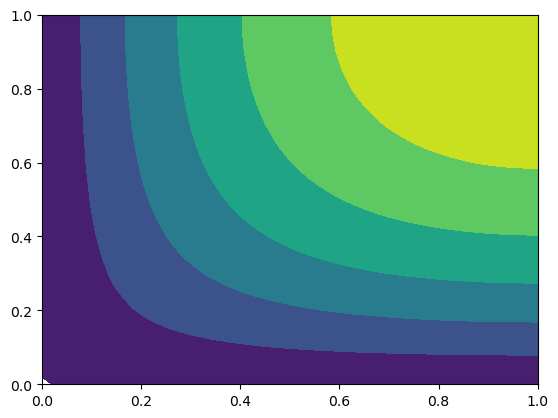

In [194]:
from matplotlib import pyplot as plt
plt.contourf(x_grid, y_grid, z_grid, 5)
plt.show()

In [ ]:
The complete script for this example is :

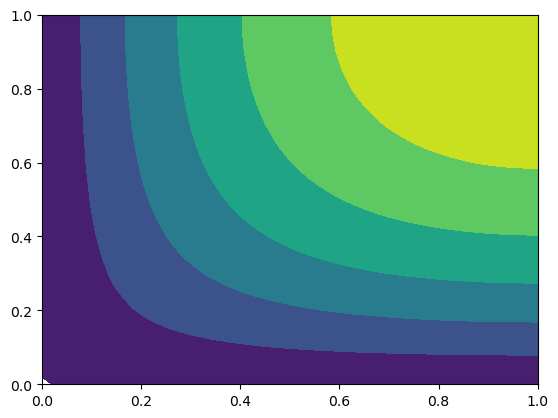

In [215]:
from esys.escript import *
from esys.escript.linearPDEs import Poisson
from esys.finley import Rectangle
from scipy.interpolate import griddata
import numpy as np
from matplotlib import pyplot as plt

# generate domain:
mydomain = Rectangle(l0=1.,l1=1.,n0=40, n1=20)

# define characteristic function of GammaD
x = mydomain.getX()
gammaD = whereZero(x[0])+whereZero(x[1])

# define PDE and get its solution u
mypde = Poisson(domain=mydomain)
mypde.setValue(f=1,q=gammaD)
u = mypde.getSolution()

# interpolate to grid and plot
x_grid = np.linspace(0., 1., 51, endpoint=True)
y_grid = np.linspace(0., 1., 51, endpoint=True)
x=mydomain.getX()[0].toListOfTuples()
y=mydomain.getX()[1].toListOfTuples()
z = interpolate(u, mydomain.getX().getFunctionSpace())
zt = z.toListOfTuples()
z_grid = griddata((x,y),zt,(x_grid[None,:],y_grid[:,None]),'linear')
plt.contourf(x_grid, y_grid, z_grid, 5)
plt.show()

To run the code in the *esys-escript* environment.  The code is in example directory. 

**run-escript poisson_matplotlib.py**

As pointed out, [matplotlib](https://matplotlib.org/) is restricted to the two-dimensional case and should be used for small problems only. As an alternative *esys-escript* supports exporting data to **VTK** and **SILO** files which can be read by visualization tools such as [mayavi](https://docs.enthought.com/mayavi/mayavi/) or [VisIt](https://wci.llnl.gov/simulation/computer-codes/visit).\mayavi\cite{mayavi} and \VisIt~\cite{VisIt}. This method is **MPI** safe and works with large 2D and 3D problems.

To write the solution u of the Poisson problem in the \VTK file format to the file \file{u.vtu} one needs to add:

In [216]:
from esys.weipa import saveVTK
saveVTK("u.vtu", sol=u)

This file can then be opened in a **VTK** compatible visualization tool. Similarly,

In [217]:
from esys.weipa import saveSilo
saveSilo("u.silo", sol=u)

True

will write u to a **SILO** file if escript was compiled with support for LLNL's **SILO** library.  The complete code is

In [219]:
from esys.escript import *
from esys.escript.linearPDEs import Poisson
from esys.finley import Rectangle
from esys.weipa import saveSilo
# generate domain:
mydomain = Rectangle(l0=1.,l1=1.,n0=40, n1=20)
# define characteristic function of Gamma^D
x = mydomain.getX()
gammaD = whereZero(x[0])+whereZero(x[1])
# define PDE and get its solution u
mypde = Poisson(domain=mydomain)
mypde.setValue(f=1,q=gammaD)
u = mypde.getSolution()
# write u to an external file
saveSilo("u.silo",sol=u)

True